توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
## download data
%%capture

# !wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
# !wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
# !unzip ADEChallengeData2016.zip
# !unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [ ]:
# function 1
def displacement(img, orig):
    h, w = img.shape[:2]
    if random.getrandbits(1):
        dx = randint(-40, -20)
    else:
        dx = randint(20, 40)
    if random.getrandbits(1):
        dy = randint(-40, -20)
    else:
        dy = randint(20, 40)
    xc = (w // 2) + dx
    yc = (h // 2) + dy
    half_w = min(xc, w - xc)
    half_h = min(yc, h - yc)
    modified_img = img[xc-half_w:xc+half_w, yc-half_h:yc+half_h, :]
    original_img = orig[(w // 2)-half_w:(w // 2)+half_w, (h // 2)-half_h:(h // 2)+half_h, :]

    return modified_img, original_img

# function 2
def rotation(img):
    h, w = img.shape[:2]
    if random.getrandbits(1):
        angle = randint(-90, -10)
    else:
        angle = randint(10, 90)
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    modified_img = cv2.warpAffine(img, M, (w, h))
    d = h / np.sin(np.abs(angle)*np.pi/180 + np.arctan(h/w))
    k = np.abs(d) / np.sqrt(h**2 + w**2)
    new_h = int(h * k)
    new_w = int(w * k)
    start_h = (h - new_h) // 2
    start_w = (w - new_w) // 2
    modified_img = modified_img[start_h:start_h + new_h, start_w:start_w + new_w, :]
    original_img = img[start_h:start_h + new_h, start_w:start_w + new_w, :]
    return modified_img, original_img


# function 3
def scaling(img):
    h, w = img.shape[:2]
    k = random.uniform(0.5,0.9)
    new_h = int(h * k)
    new_w = int(w * k)
    start_h = (h - new_h) // 2
    start_w = (w - new_w) // 2
    modified_img = img[start_h:start_h + new_h, start_w:start_w + new_w, :]
    return modified_img

# function 4
def Brightness(img):  ## for augmentation
  ## To Do

  return img



# function 5
def bluring(img):# for augmentation
  ## To Do

  return img

# function 6
def gaussian_noise(img):#for augmentation
  ## To Do

  return img





In [ ]:
def make_sq(img):
    h, w = img.shape[:2]
    new_size = min(h,w)
    start_h = (h - new_size) // 2
    start_w = (w - new_size) // 2
    sq_img = img[start_h:start_h + new_size, start_w:start_w + new_size, :]
    return sq_img

In [ ]:
train_dir = '/content/ADEChallengeData2016/images/training'
train_image_files = sorted(glob.glob(os.path.join(train_dir, '*.jpg')))

val_dir = '/content/ADEChallengeData2016/images/validation'
val_image_files = sorted(glob.glob(os.path.join(val_dir, '*.jpg')))

test_dir = '/content/release_test/testing'
test_image_files = sorted(glob.glob(os.path.join(test_dir, '*.jpg')))

output_train_dir = '/content/Q3Dataset/training'
train_orig_dir = os.path.join(output_train_dir, 'original')
train_modif_dir = os.path.join(output_train_dir, 'modified')
train_label_dir = os.path.join(output_train_dir, 'labels')
os.makedirs(train_orig_dir, exist_ok=True)
os.makedirs(train_modif_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)

output_val_dir = '/content/Q3Dataset/validation'
val_orig_dir = os.path.join(output_val_dir, 'original')
val_modif_dir = os.path.join(output_val_dir, 'modified')
val_label_dir = os.path.join(output_val_dir, 'labels')
os.makedirs(val_orig_dir, exist_ok=True)
os.makedirs(val_modif_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

output_test_dir = '/content/Q3Dataset/test'
test_orig_dir = os.path.join(output_test_dir, 'original')
test_modif_dir = os.path.join(output_test_dir, 'modified')
test_label_dir = os.path.join(output_test_dir, 'labels')
os.makedirs(test_orig_dir, exist_ok=True)
os.makedirs(test_modif_dir, exist_ok=True)
os.makedirs(test_label_dir, exist_ok=True)


In [ ]:
# generating the datasets

for img_path in tqdm(train_image_files):    # train dataset

    label = torch.randint(2,(3,))  # choose what transforms are applied to the image
    while (label.sum().item() == 0) or (label.sum().item() == 3):
        label = torch.randint(2,(3,))

    image = IM(img_path)
    orig = make_sq(image)
    modif = orig

    if label[0]:   # rotation
        modif, orig = rotation(modif)
    if label[1]:   # displacement
        modif, orig = displacement(modif, orig)
    if label[2]:   # scaling
        if random.getrandbits(1):   # scale down
            modif = scaling(modif)
        else:   # scale up
            orig = scaling(orig)

    orig = cv2.resize(orig, (224, 224))
    modif = cv2.resize(modif, (224, 224))

    img_name = os.path.splitext(os.path.basename(img_path))[0]
    orig_path = os.path.join(train_orig_dir, f'{img_name}_orig.jpg')
    modif_path = os.path.join(train_modif_dir, f'{img_name}_modif.jpg')
    label_path = os.path.join(train_label_dir, f'{img_name}_label.txt')

    cv2.imwrite(orig_path, orig)
    cv2.imwrite(modif_path, modif)

    # Save labels as a text file
    with open(label_path, 'w') as label_file:
        label_file.write(' '.join(map(str, label.tolist())))

for img_path in tqdm(val_image_files):    # validation dataset

    label = torch.randint(2,(3,))  # choose what transforms are applied to the image
    while (label.sum().item() == 0) or (label.sum().item() == 3):
        label = torch.randint(2,(3,))

    image = IM(img_path)
    orig = make_sq(image)
    modif = orig

    if label[0]:   # rotation
        modif, orig = rotation(modif)
    if label[1]:   # displacement
        modif, orig = displacement(modif, orig)
    if label[2]:   # scaling
        if random.getrandbits(1):   # scale down
            modif = scaling(modif)
        else:   # scale up
            orig = scaling(orig)

    orig = cv2.resize(orig, (224, 224))
    modif = cv2.resize(modif, (224, 224))

    img_name = os.path.splitext(os.path.basename(img_path))[0]
    orig_path = os.path.join(val_orig_dir, f'{img_name}_orig.jpg')
    modif_path = os.path.join(val_modif_dir, f'{img_name}_modif.jpg')
    label_path = os.path.join(val_label_dir, f'{img_name}_label.txt')

    cv2.imwrite(orig_path, orig)
    cv2.imwrite(modif_path, modif)

    # Save labels as a text file
    with open(label_path, 'w') as label_file:
        label_file.write(' '.join(map(str, label.tolist())))

for img_path in tqdm(test_image_files):    # train dataset

    label = torch.randint(2,(3,))  # choose what transforms are applied to the image
    while (label.sum().item() == 0) or (label.sum().item() == 3):
        label = torch.randint(2,(3,))

    image = IM(img_path)
    orig = make_sq(image)
    modif = orig

    if label[0]:   # rotation
        modif, orig = rotation(modif)
    if label[1]:   # displacement
        modif, orig = displacement(modif, orig)
    if label[2]:   # scaling
        if random.getrandbits(1):   # scale down
            modif = scaling(modif)
        else:   # scale up
            orig = scaling(orig)

    orig = cv2.resize(orig, (224, 224))
    modif = cv2.resize(modif, (224, 224))

    img_name = os.path.splitext(os.path.basename(img_path))[0]
    orig_path = os.path.join(test_orig_dir, f'{img_name}_orig.jpg')
    modif_path = os.path.join(test_modif_dir, f'{img_name}_modif.jpg')
    label_path = os.path.join(test_label_dir, f'{img_name}_label.txt')

    cv2.imwrite(orig_path, orig)
    cv2.imwrite(modif_path, modif)

    # Save labels as a text file
    with open(label_path, 'w') as label_file:
        label_file.write(' '.join(map(str, label.tolist())))

100%|██████████| 3352/3352 [00:45<00:00, 74.46it/s]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !zip -r -q "/content/Q3Dataset.zip" "/content/Q3Dataset"
# !cp "/content/Q3Dataset.zip" "/content/drive/My Drive"

In [ ]:
# !rm Q3Dataset.zip
# !rm -rf "/content/Q3Dataset"

In [4]:
!cp "/content/drive/My Drive/Q3Dataset.zip" "/content"
!unzip -q Q3Dataset.zip

# Training

In [3]:
class CustomDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.orig_files = sorted(glob.glob(os.path.join(root_dir, 'original', '*.jpg')))
        self.modif_files = sorted(glob.glob(os.path.join(root_dir, 'modified', '*.jpg')))
        self.label_files = sorted(glob.glob(os.path.join(root_dir, 'labels', '*.txt')))
        self.transform = transform

    def __len__(self):
        return len(self.orig_files)

    def __getitem__(self, idx):
        orig_path = self.orig_files[idx]
        modif_path = self.modif_files[idx]
        label_path = self.label_files[idx]

        orig = IM(orig_path)
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
        orig = self.transform(orig)

        modif = IM(modif_path)
        modif = cv2.cvtColor(modif, cv2.COLOR_BGR2RGB)
        modif = self.transform(modif)

        with open(label_path, 'r') as label_file:
            label_str = label_file.read().strip().split(' ')
            label = torch.tensor(list(map(float, label_str)))

        return {'orig': orig, 'modif': modif, 'label': label}


In [4]:
train_loader = CustomDataset(root_dir='/content/content/Q3Dataset/training', transform=transforms.ToTensor())
test_loader= CustomDataset(root_dir='/content/content/Q3Dataset/test', transform=transforms.ToTensor())
val_loader = CustomDataset(root_dir='/content/content/Q3Dataset/validation', transform=transforms.ToTensor())
batch_size = 16
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_loader, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)

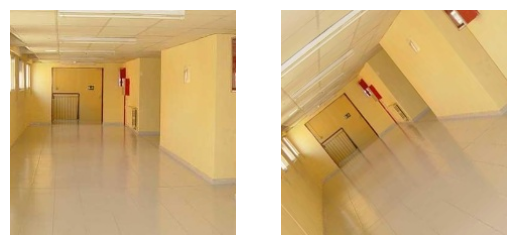

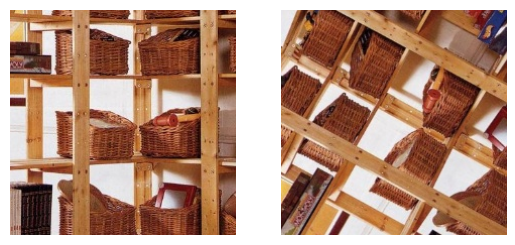

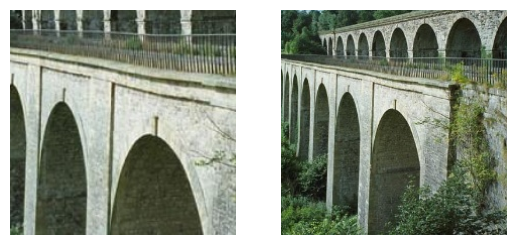

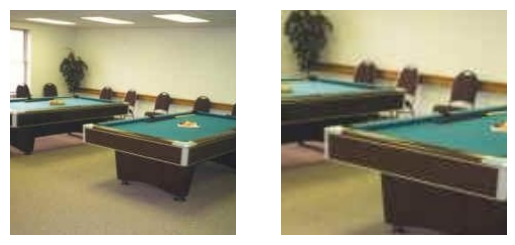

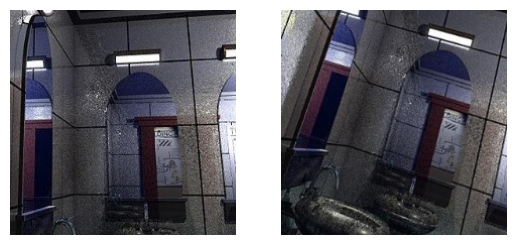

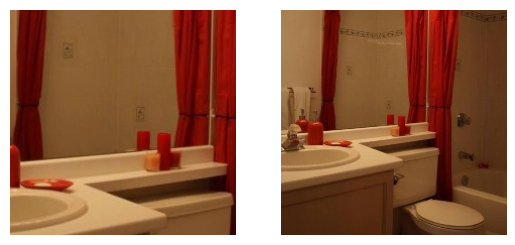

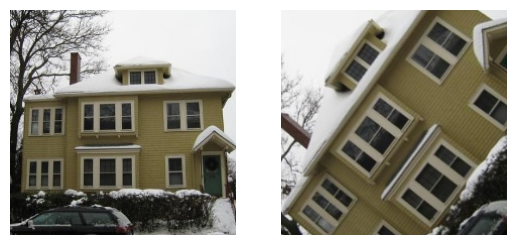

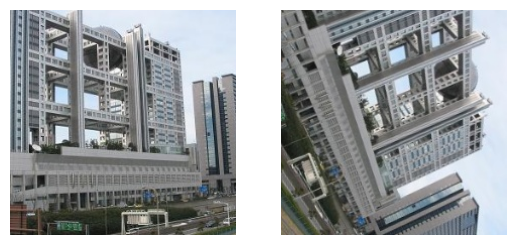

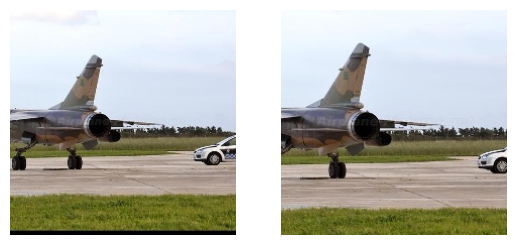

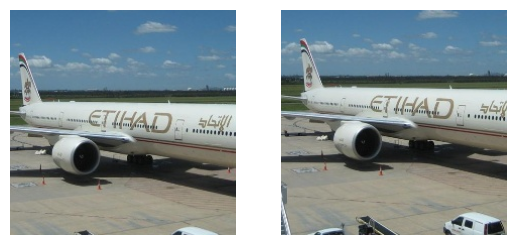

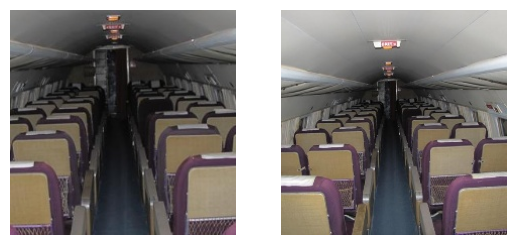

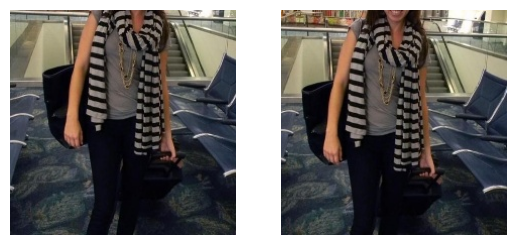

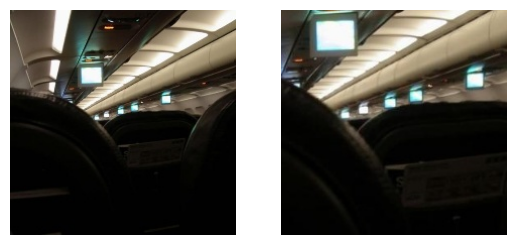

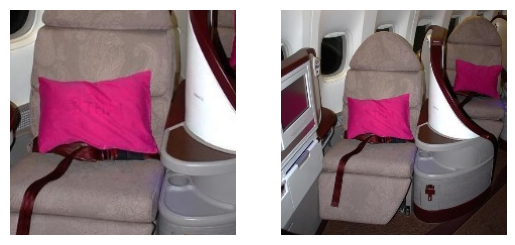

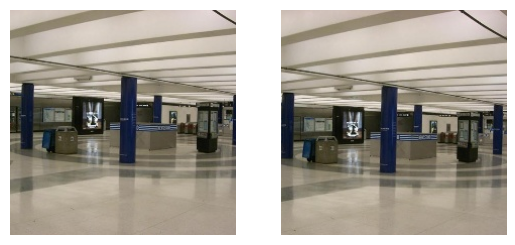

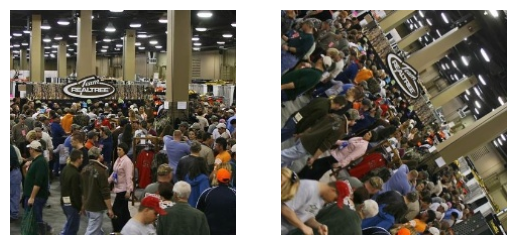

In [5]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
batch = next(iter(train_loader))
for i in range(8):
    orig = batch['orig']
    modif = batch['modif']
    label = batch['label']
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(orig[i].permute(1,2,0))
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(modif[i].permute(1,2,0))

for batch in test_loader:
    for i in range(8):
        orig = batch['orig']
        modif = batch['modif']
        label = batch['label']
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.imshow(orig[i].permute(1,2,0))
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.imshow(modif[i].permute(1,2,0))
    break

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

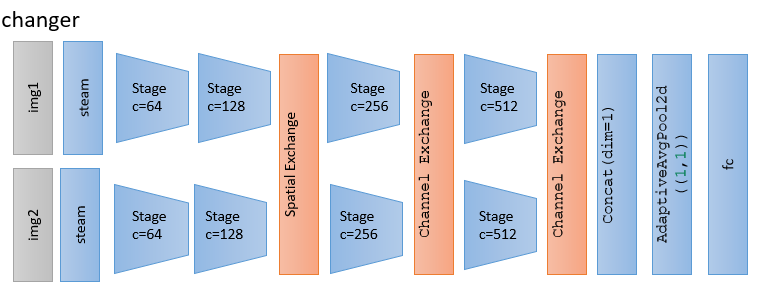

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


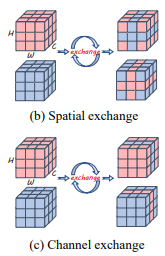

In [5]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

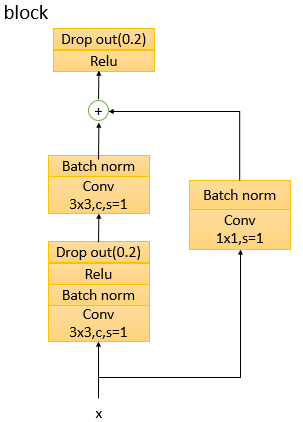

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





In [6]:
##To Do
class Block(nn.Module):
    def __init__(self, in_channels=64, c=64):
        super(Block, self).__init__()

        self.path1 = nn.Sequential(
            nn.Conv2d(in_channels, c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(c, c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c)
        )

        self.path2 = nn.Sequential(
            nn.Conv2d(in_channels, c, kernel_size=1, stride=1),
            nn.BatchNorm2d(c)
        )

        self.common_path = nn.Sequential(
            nn.ReLU(),
            nn.Dropout2d(0.2)
        )


    def forward(self, x):
        out1 = self.path1(x)
        out2 = self.path2(x)
        out = out1 + out2
        out = self.common_path(out)
        return out

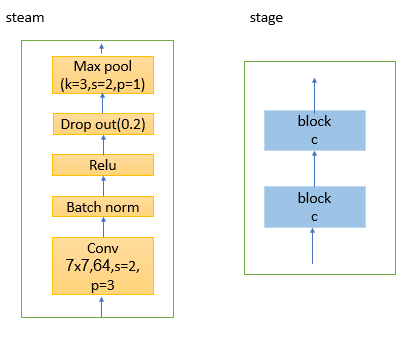

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [7]:
#To Do
class changer(nn.Module):
  def __init__(self,Block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()
    self.in_channels = 3
    self.steam = nn.Sequential(
        nn.Conv2d(self.in_channels, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout2d(0.2),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    self.stage1 = self._make_stage(64, 64, Block)
    self.stage2 = self._make_stage(64, 128, Block)
    self.sp_ex= SpatialExchange()
    self.stage3 = self._make_stage(128, 256, Block)
    self.ch_ex1 = ChannelExchange()
    self.stage4 = self._make_stage(256, 512, Block)
    self.ch_ex2 = ChannelExchange()
    self.fc = nn.Linear(1024, 3)


  def _make_stage(self, in_channels, out_channels, Block):
    layers=[Block(in_channels, out_channels), Block(out_channels, out_channels)]
    self.in_channels = out_channels
    return nn.Sequential(*layers)


  def forward(self,x1,x2):
    out1 = self.steam(x1)
    out2 = self.steam(x2)
    out1 = self.stage1(out1)
    out2 = self.stage1(out2)
    out1 = self.stage2(out1)
    out2 = self.stage2(out2)
    out1, out2 = self.sp_ex(out1, out2)
    out1 = self.stage3(out1)
    out2 = self.stage3(out2)
    out1, out2 = self.ch_ex1(out1, out2)
    out1 = self.stage4(out1)
    out2 = self.stage4(out2)
    out1, out2 = self.ch_ex2(out1,out2)
    out = torch.cat([out1, out2], dim=1)
    out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out


In [8]:
## To Do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model=changer(Block,SpatialExchange,ChannelExchange).to(device)

citeration = nn.BCEWithLogitsLoss()
optimizer= optim.Adam(model.parameters(), lr=0.001)

##Train & validation


In [9]:
Loss_train=[]
Loss_val=[]
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    corrects = 0
    total = 0
    total_loss = 0.0

    for batch in tqdm(train_loader):
        orig, modif, label = batch["orig"].to(device), batch["modif"].to(device), batch["label"].to(device)
        output = model(orig, modif)
        loss = citeration(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = torch.sigmoid(output) > 0.5
        corrects += (pred == label).sum().item()
        total += label.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_acc = corrects / total
    Loss_train.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Loss_train: {avg_train_loss:.3f}, Acc_train: {train_acc:.3f}')

    corrects = 0
    total = 0
    total_loss = 0.0

    for batch in train_loader:
        orig, modif, label = batch["orig"].to(device), batch["modif"].to(device), batch["label"].to(device)
        output = model(orig, modif)
        loss = citeration(output, label)
        total_loss += loss.item()
        pred = torch.sigmoid(output) > 0.5
        corrects += (pred == label).sum().item()
        total += label.size(0)

    avg_val_loss = total_loss / len(val_loader)
    val_acc = corrects / total
    Loss_val.append(avg_val_loss)
    print(f'Loss_validation: {avg_val_loss:.3f}, Acc_validation: {val_acc:.3f}')


100%|██████████| 1264/1264 [20:29<00:00,  1.03it/s]


Epoch [1/5]
Loss_train: 0.694, Acc_train: 1.568


OutOfMemoryError: ignored

#Test


In [ ]:
checkpoint = torch.load('#To Do')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## To Do test

print(f' loss_test= {:.3f}, acc_test={()}')


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟